In [1]:
%matplotlib inline
import pandas as pd

import numpy as np
from __future__ import division
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.grid'] = False

import logging
logger = logging.getLogger()

6 Frequent Itemsets
===========

### 6.1 The Market-Basket Model
Each **Basket** consists of a set of **items**(an itemset)      

+ The number of items in a basket is small.

+ The number of baskets is usually very large.

+ Basket are sets, and in priciple items can appear only once.


##### Definition of Frequent Itemses
a set of items that appears in many baskets is said to be "frequent".

**support**: if ${I}$ is a set of items, the support of ${I}$ is the number of baskets for which I is a subset.

Assume $s$ is the support threshold, then we say ${I}$ is frequent if its support is $s$ or more.

In [2]:
logger.setLevel('WARN')

data_raw = [
    ['Cat', 'and', 'dog', 'bites'],
    ['Yahoo', 'news', 'claims', 'a', 'cat', 'mated', 'with', 'a', 'dog', 'and', 'produced', 'viable', 'offspring'],
    ['Cat', 'killer', 'likely', 'is', 'a', 'big', 'dog'],
    ['Professional', 'free', 'advice', 'on', 'dog', 'training', 'puppy', 'training'],
    ['Cat', 'and', 'kitten', 'training', 'and', 'behavior'],
    ['Dog', '&', 'Cat', 'provides', 'dog', 'training', 'in', 'Eugene', 'Oregon'],
    ['Dog', 'and', 'cat', 'is', 'a', 'slang', 'term', 'used', 'by', 'police', 'officers', 'for', 'a', 'male-female', 'relationship'],
    ['Shop', 'for', 'your', 'show', 'dog', 'grooming', 'and', 'pet', 'supplies']
]

data = [set(map(str.lower, x)) for x in data_raw]
data = pd.Series(data)

def calc_occurrence_of_doubletons(df, data):
    logger.info('df: \n{}\n'.format(df))
    for i_ in df.index:
        for c_ in df.columns:
            if not np.isnan(df.loc[i_,c_]):
                key = {i_, c_}
                ind_ = [ind+1 for ind, is_in in enumerate(data.apply(lambda x: key.issubset(x))) if is_in]
                df.loc[i_,c_] = ','.join([str(x) for x in ind_]) 
    return df

mask = [
    [1, 1, 1, 1],
    [1, 1, 1, np.nan],
    [1, 1, np.nan, np.nan],
    [1, np.nan, np.nan, np.nan]
]
df = pd.DataFrame(mask, index=['dog', 'cat', 'and', 'a'], columns=['training', 'a', 'and', 'cat'])
calc_occurrence_of_doubletons(df, data)

,training,a,and,cat
dog,"4,6","2,3,7","1,2,7,8","1,2,3,6,7"
cat,"5,6","2,3,7","1,2,5,7",NaN
and,5,"2,7",NaN,NaN
a,,NaN,NaN,NaN


##### applications
1. Related concepts

2. Plagiarism

3. Biomarkers

#### 6.1.3 Associaton Rules
an association rule $I \to j$:    
if all of the items in $I$ appear in some basket, then $j$ is "likely" to appear in that basket as well.

**confidence**: $$\text{confidence}(I \to j) = \frac{\text{support}(I \cup \{j\})}{\text{support}(I)}$$

**interest**: $$\text{interest}(I \to j) = \text{confience}(I \to j) - \frac{\text{support}(j)}{m}$$ where $m$ is the number of all baskets.


##### Finding Association Rules with High Confidence
if $j$ is a set of $n$ items that is found to be frequent, then we have $n$ candidates: $J - \{j\} \to j$ for each $j$ in $J$. Then their confidence can be calculated.

cons: assumed that there are not too many frequent itemsets, since each one found must be acted upon.      
solution: adjust the support threshold $s$ so that we do not get too many frequent itemsets.

##### 6.1.5 Exercise for Section 6.1
略

### 6.2 Market Baskets and the A-Priori Algorithm
#### 6.2.1 Representation of Market-Basket Data
We assume that:    
+ market-basket data is stored in a file basket-by-basket.    
+ the size of the file of baskets is sufficiently large that it doesn't fit in main memory.     
+ a major cost of any algorithm is the time it takes to read the baskets from disk.      
  Why we miss the time it takes to generate all the subsets of size $k$?      
  1. $k$ is usually small, never grows beyond 2 or 3.     
  2. It's possible to eliminate many of items in procession.     
      
  Measure: only the number of passes taken by the algorithm matters.

#### 6.2.2 Use of Main Memory for Itemset Counting
Each algorithm has a limit on how many items it can deal with.

##### Coding items as integers
In general, we need a hash table that translates items as they appear in the file to integers.

##### Count a pair $\{i,j\}$
1. The Triangular-Matrix Method      
   + Use the entry $a[i,j]$ in a two-dimensional array.     
     make half the array __useless__.      
   + Use a one-dimensional triangular array.     
     We store in $a[k]$ the count for the pair $\{i,j\}$, where $k = (i-1)(n-\frac{i}{2}) + (j-i), \, 1 \leq i < j \leq n$.

2. The Triples Method     
We can store counts as triples $[i,j,c]$.    
eg. a hash table with $i$ and $j$ as the search key.

pros: don't store anything if a pair counts 0.     
cons: store 3 integers for every pair.

###### comparison
use the triangular matrix if at least 1/3 of the $C_n^2$ possible pairs actually appear in some basket.    
use the triples method if significatly fewer than 1/3 of the possible pairs occur.

We might be better off using the triples method, because it would be normal to be a sufficiently uneven distribution  of items even if the were ten or a hundred times as many baskets.

#### 6.2.3 Monotonicity of Itemsets
__monotonicity__ for itemsets:     
If a set $I$ of items is frequent, then so it every subsets of $I$.

If we are given a support threshold $s$, then we say an itemset is __maximal__ if no superset is frequent.

#### 6.2.4 Tyranny of Counting Pairs
The number of items is rarely so large we cannot count all the singleton sets in main memory at the same time, while it would be impossible to count the larger sets - triples, quadruples, since $C_n^k$ - the number of them - is too large.

#### 6.2.5 The A-Priori Algorithm
to avoid counting many triples or larger sets.

1. The First Pass
   two tables: one is used to translate item names to integers, and another one is used to count.
   
2. Between the Passes     
   we get frequent sets after we set the threshold $s$.
   
3. The Second Pass     
   We count all pairs of the frequent sets as follows:     
   1. For each basket, identify its frequent items in frequent sets.     
   2. Generate all pairs. of its frequent items.     
   3. Add one for each pairs above.

#### 6.2.6 A-Priori for All Frequent Itemsets

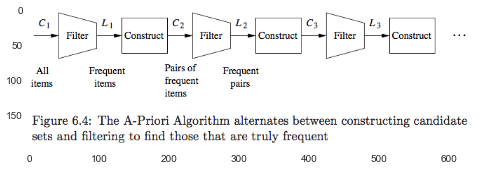

In [3]:
plt.imshow(plt.imread('./res/fig6_4.png'))

#### 6.2.7 Exercises for Section 6.2
略

### 6.3 Handling Larger Datasets in Main Memory
A-Priori Algorithm: the greatest requirement for main memory when counting of $C_2$.  $\to$ **idea**: cut down on the size of $C_2$.

#### 6.3.1 The Algorithm of Park, Chen and Yu (PCY)
1. 1st pass:     
   + count single item $C_1$.     
   + hash each pairs in the basket to the bucket, and add 1.
   
2. during pass:    
   + filter frequent items $L_1$.      
   + filter frequent buckets. $to$ summaried as a *bitmap*.      
 
3. $C_2$, pairs ${i,j}$:     
   1. $i$ and $j$ are frequent items.     
   2. ${i,j}$ hashes to a frequent bucket.    
   
pros: $C_2 \downarrow$.     
cons: cannot renumber $1,\dotsc,m$ $\to$ cannot use triangular matrix $\to$ **ONLY use the triple method**.

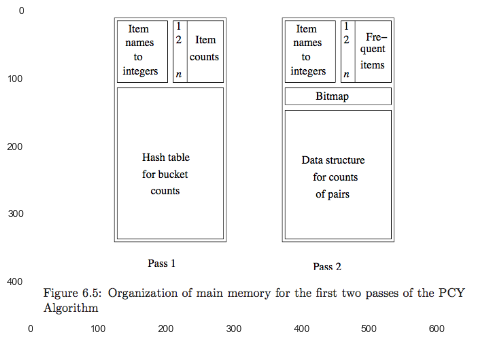

In [4]:
plt.imshow(plt.imread('./res/fig6_5.png'))

#### 6.3.2 The Multistage Algorithm
It improves upon PCA by using several *successive* hash tables to reduce further the number of candidate pairs. 

1. 1st pass is the same as of PCY.

2. 2nd pass:     
   We hash ${i,j}$ if and only if:    
   + $i$ and $j$ are both frequent.     
   + ${i,j}$ hashed to a frequent bucket of $B_1$ on the 1st pass.     
   
   Then summarized as a bitmap $B_2$.
   
3. $C_2$ pairs ${i,j}$:     
   + $i$ and $j$ are both frequent items.    
   + ${i,j}$ hashed to a frequent bucket in $B_1$.
   + ${i,j}$ hashed to a frequent bucket in $B_2$ as well.
   
Attention:     
Each pass must store the bitmaps, eventually, there is not enough space left to count if used too many stages.

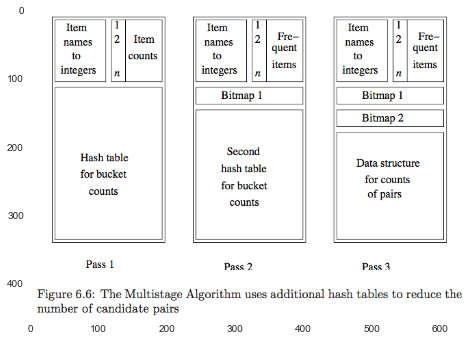

In [5]:
plt.imshow(plt.imread('./res/fig6_6.png'))

#### 6.3.3 The Multihash Algorithm
use two hash functions and two seperate hash tables on the 1st pass.

The danger of using two hash tables on one pass is that each hash table has half as many buckets as the one large hash table of PCY. $\implies$ the average count of a bucket for PCY is much lower than the support threshold.

$C_2$: $i$ and $j$ must both be frequent, and the pair must have hashed to a frequent bucket according to both hash tables.

The **risk** is that should we use too many hash tables, the average count for a bucket will exceed the support threshold.      
$\implies$ the probability an infrequent pair will be a candidate rises, rather than falls, if we add another hash table.

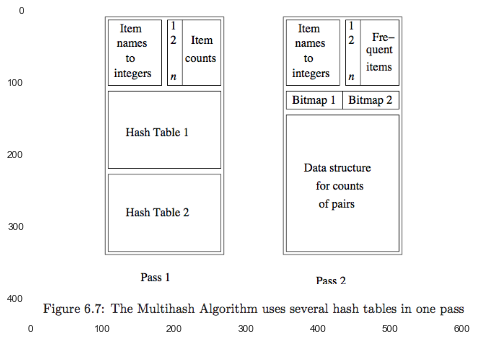

In [6]:
plt.imshow(plt.imread('./res/fig6_7.png'))

#### 6.3.4 Exercises for Section 6.3
`#maybe`

### 6.4 Limited-Pass Algorithms
Main memory is too small. $to$ $k$ passes to compute.    
solution: it's not essential to discover every frequent itemset.     

#### 6.4.1 The Simple, Randomized Algorithm
to pick a random subset of the baskets and adjust the support thresold.

The *safety* way:   
read the entire dataset one by one,     
and for each basket, select that basket for the sample with some fixed probility $p$.

##### Avoiding Errors
eliminate False Positives: making a pass through the full datasets and counting all the candidates to check.     

reduce False Negatives:        
use smaller threshold for the samples, such as $0.9ps$, and so push more itemsets to be checked.       
cons: need more main memory.

#### 6.4.3 The Algorithm of Savasere, Omiecinski, and Navathe(SON)
Avoid both Fasle Negatives and False Positives, at the cost of making two full passes.

1. 1st pass to find candidates.     
   1. Divide the input files into chunks.     
   2. Treat each chunks as sample, use $ps$ as the thresold.    
   3. *candidate* itemsets: the union of all the itemsets that have been found frequent for *one or more* chunks.      
      idea: every itemset that's frequent in the whole is frequent in at least one chunk.
      
2. 2nd pass to count all the candidates and check.


##### The SON Algorithm and MapReduces
1. First Map Function: $(F,1)$, where $F$ is a frequent itemset from the sample.   

2. First Reduce Function: combine all the $F$ to construct the candidate itemsets.

3. Second Map Function: $(C,v)$, where $C$ is one of the candidate sets and $v$ is the support.

4. Second Reduce Function: Sum and filter out the frequent itemsets.

#### 6.4.5 Toivonen's Algorithm
pass over a small sample and one full pass over the data.      
avoid both FN and FP, but there is a small probability that it will fail to produce any answer at all.

1. 1st pass: candidates     
   1. select a small sample.     
   2. use a smaller threshold, such as $0.9ps$, to find candidate frequent itemsets $F$.     
   3. construct the *negative border*($N$):     
      They are not frequent in the sample, but all of their *immediate subsets*(subsets constructed by deleting exactly one item) are frequent in the sample.
      
2. 2nd pass: check, counting all $F$ and $N$.     
   + if no member of $N$ is frequent in the whole datasets. $to$ output the $F$.   
   + otherwise, give no answer and resample again.
   
##### Why it works.
1. eliminate FP $gets$ check in the full datasets.    

2. eliminate FN(namely, find all *real* frequent itemset in the *sample*):      
   Proof:     
   When no member of the $N$ is frequent in the whole,     
   there can be no itemset $S$ whatsoever that is:
   1. Frequent in the whole, but     
   2. In neither $N$ or $F$.
          
   Proof by Contradiction:      
   Suppose $S$ exist, but the algorithm gives OUTPUT when no member of the $N$ is frequent in the whole.    
   
   Let $T$ be a subset of $S$ that is of the smallest possible size among all subsets of $S$ that are not frequent in the sample.      
   + smallest $to$ all of its immediate subsets are frequent.       
   + $T$ is not frequent.    
   So, $T \in N$.     
   While $T$ is frequent in the whold datasets, $\to$ fail to answer. CONTRATY with output.

##### 6.4.7 Exercises for Section 6.4
略

### 6.5 Counting Frequent Items in a Stream
For stream, we must think of the support threshold $s$ as a fraction of the baskets in which an itemset must appear in order to be considered frequent.

#### 6.5.1 Sampling Methods for Streams
When the frquent-itemsets algorithm finishes, we have an estimate of the frequent itemsets in the stream.    
Then we have several options:

1. Use the collection at handy, but start running another iteration immediately.

2. Continue to count the frequent itemsets, and     
   + drop someone when they reach below $s$,      
   + add new frequent itemsets.     
     eg:     
     + Periodically gather.      
     + Add negative border.(most potential itemsets)

#### 6.5.2 Frequent Itemsets in Decaying Windows
a decaying window on a stream:       
1. picking a small constant $c$.    
2. giving the $i$th element the weight $(1-c)^i \approx e^{-ci}$.

record all items whose score was at least $1/2$.

##### baskets $\to$ items
1. unfold directly. $\{a,b\}, \{c,d\} \to a, b, c, d$     
   cons: We want to find all frequent itemsets, not just singleton itemsets.

2. Start scoring certain itemsets as soon as we see one instance, but be conservative about which itemsets we start.  $gets$  too many counts.      
   eg: Only start an itemset $I$ if all its immediate subsets are already being scored.

#### 6.5.3 Hybird Methods
The big disadvantage of decaying window is:      
It requires us to maintain scores for each itemset with a score of at least $1/2$,           
while limiting by $c$ will force us to accept information that tracks the local fluctuations in frequency too closely.

Solution:     
1. Use sampling method to find candidates and give them initial scores.      
2. When the score of an candidate reach upper $s$, then it's collected as frequent-itemsets.

#### 6.5.4 Exercises for Section 6.5
略